In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

KAGGLE_DATASET_PATH = "/kaggle/input/cvpr-face-data-35-student/CVPR_face_data" 

IMG_SIZE = 128
SEED = 42

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.19.0
GPU Available: []


In [14]:
# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_face(img_path, target_size=(128, 128)):
    """
    Reads an image, detects the face, crops it, and resizes it.
    If no face is found, returns the resized original.
    """
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        # Convert to grayscale for detection
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect faces
        faces = face_cascade.detectMultiScale(
            gray, 
            scaleFactor=1.1, 
            minNeighbors=4, 
            minSize=(30, 30)
        )

        if len(faces) > 0:
            # Crop the first face found (x, y, w, h)
            (x, y, w, h) = faces[0]
            face = img[y:y+h, x:x+w]
        else:
            # Fallback: use entire image if no face detected
            face = img

        # Resize to target size
        face = cv2.resize(face, target_size)
        # Convert BGR (OpenCV default) to RGB
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        return face
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [5]:
def load_dataset(data_dir, img_size):
    """
    Iterates through class folders, detects faces, and loads data into memory.
    """
    X = []
    y = []
    
    # Ensure data_dir exists
    if not os.path.exists(data_dir):
        print(f"Error: Directory {data_dir} not found. Please check KAGGLE_DATASET_PATH.")
        return np.array([]), np.array([]), []

    # Get class names (subfolders)
    class_names = sorted([d for d in os.listdir(data_dir) 
                         if os.path.isdir(os.path.join(data_dir, d))])
    class_map = {name: i for i, name in enumerate(class_names)}

    print(f"Found {len(class_names)} classes: {class_names}")
    print("Starting data loading and face cropping...")

    total_files = 0
    for cls in class_names:
        cls_dir = os.path.join(data_dir, cls)
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
         
        
        print(f"Processing class '{cls}': {len(files)} images")
        
        for fname in files:
            path = os.path.join(cls_dir, fname)
            processed_img = detect_and_crop_face(path, (img_size, img_size))
            
            if processed_img is not None:
                X.append(processed_img)
                y.append(class_map[cls])
                total_files += 1

    print(f"Done! Loaded {len(X)} images.")
    return np.array(X), np.array(y), class_names


In [6]:
# Load Data
X, y, class_names = load_dataset(KAGGLE_DATASET_PATH, IMG_SIZE)

Found 35 classes: ['21-45902-3', '22-46139-1', '22-46258-1', '22-46275-1', '22-46536-1', '22-46590-1', '22-47813-2', '22-47892-2', '22-47934-2', '22-47968-2', '22-48005-2', '22-48021-2', '22-48023-2', '22-48064-2', '22-48133-2', '22-48205-2', '22-48354-3', '22-48569-3', '22-48582-3', '22-48833-3', '22-49037-3', '22-49068-3', '22-49196-3', '22-49338-3', '22-49355-3', '22-49421-3', '22-49453-3', '22-49643-3', '22-49783-3', '22-49791-3', '22-49824-3', '22-49843-3', '22-49852-3', '23-50254-1', '23-50346-1']
Starting data loading and face cropping...
Processing class '21-45902-3': 20 images
Processing class '22-46139-1': 20 images
Processing class '22-46258-1': 15 images
Processing class '22-46275-1': 20 images
Processing class '22-46536-1': 9 images
Processing class '22-46590-1': 20 images
Processing class '22-47813-2': 19 images
Processing class '22-47892-2': 20 images
Processing class '22-47934-2': 20 images
Processing class '22-47968-2': 20 images
Processing class '22-48005-2': 20 image

In [3]:
SAVE_PATH = "/kaggle/working/full_face_data.npz"

def save_full_data(path, X, y, class_names):
    """
    Saves the complete dataset (X, y) and class names.
    Use this BEFORE train_test_split.
    """
    print(f"Saving full dataset to {path}...")
    
    # We save as compressed numpy array
    np.savez_compressed(
        path,
        X=X,
        y=y,
        class_names=class_names
    )
    
    file_size = round(os.path.getsize(path) / 1024 / 1024, 2)
    print(f"Data saved successfully! Size: {file_size} MB")

def load_full_data(path):
    """
    Loads the full X, y, and class_names.
    """
    if not os.path.exists(path):
        print(f"File {path} not found. You need to run face detection first.")
        return None, None, None
        
    print(f"Loading data from {path}...")
    data = np.load(path, allow_pickle=True)
    
    X = data['X']
    y = data['y']
    class_names = data['class_names']
    
    print("Full data loaded!")
    print(f"Total Images: {X.shape[0]}")
    print(f"Image Size:   {X.shape[1:]}")
    return X, y, class_names

#  Save the data
# if 'X' in globals() and 'y' in globals():
#     save_full_data(SAVE_PATH, X, y, class_names)
# else:
#     print("X and y not found in memory. Please run 'load_dataset' first.")


# Load the Data
X, y, class_names = load_full_data("/kaggle/input/process-face-data/full_face_data.npz")

Loading data from /kaggle/input/process-face-data/full_face_data.npz...
Full data loaded!
Total Images: 658
Image Size:   (128, 128, 3)


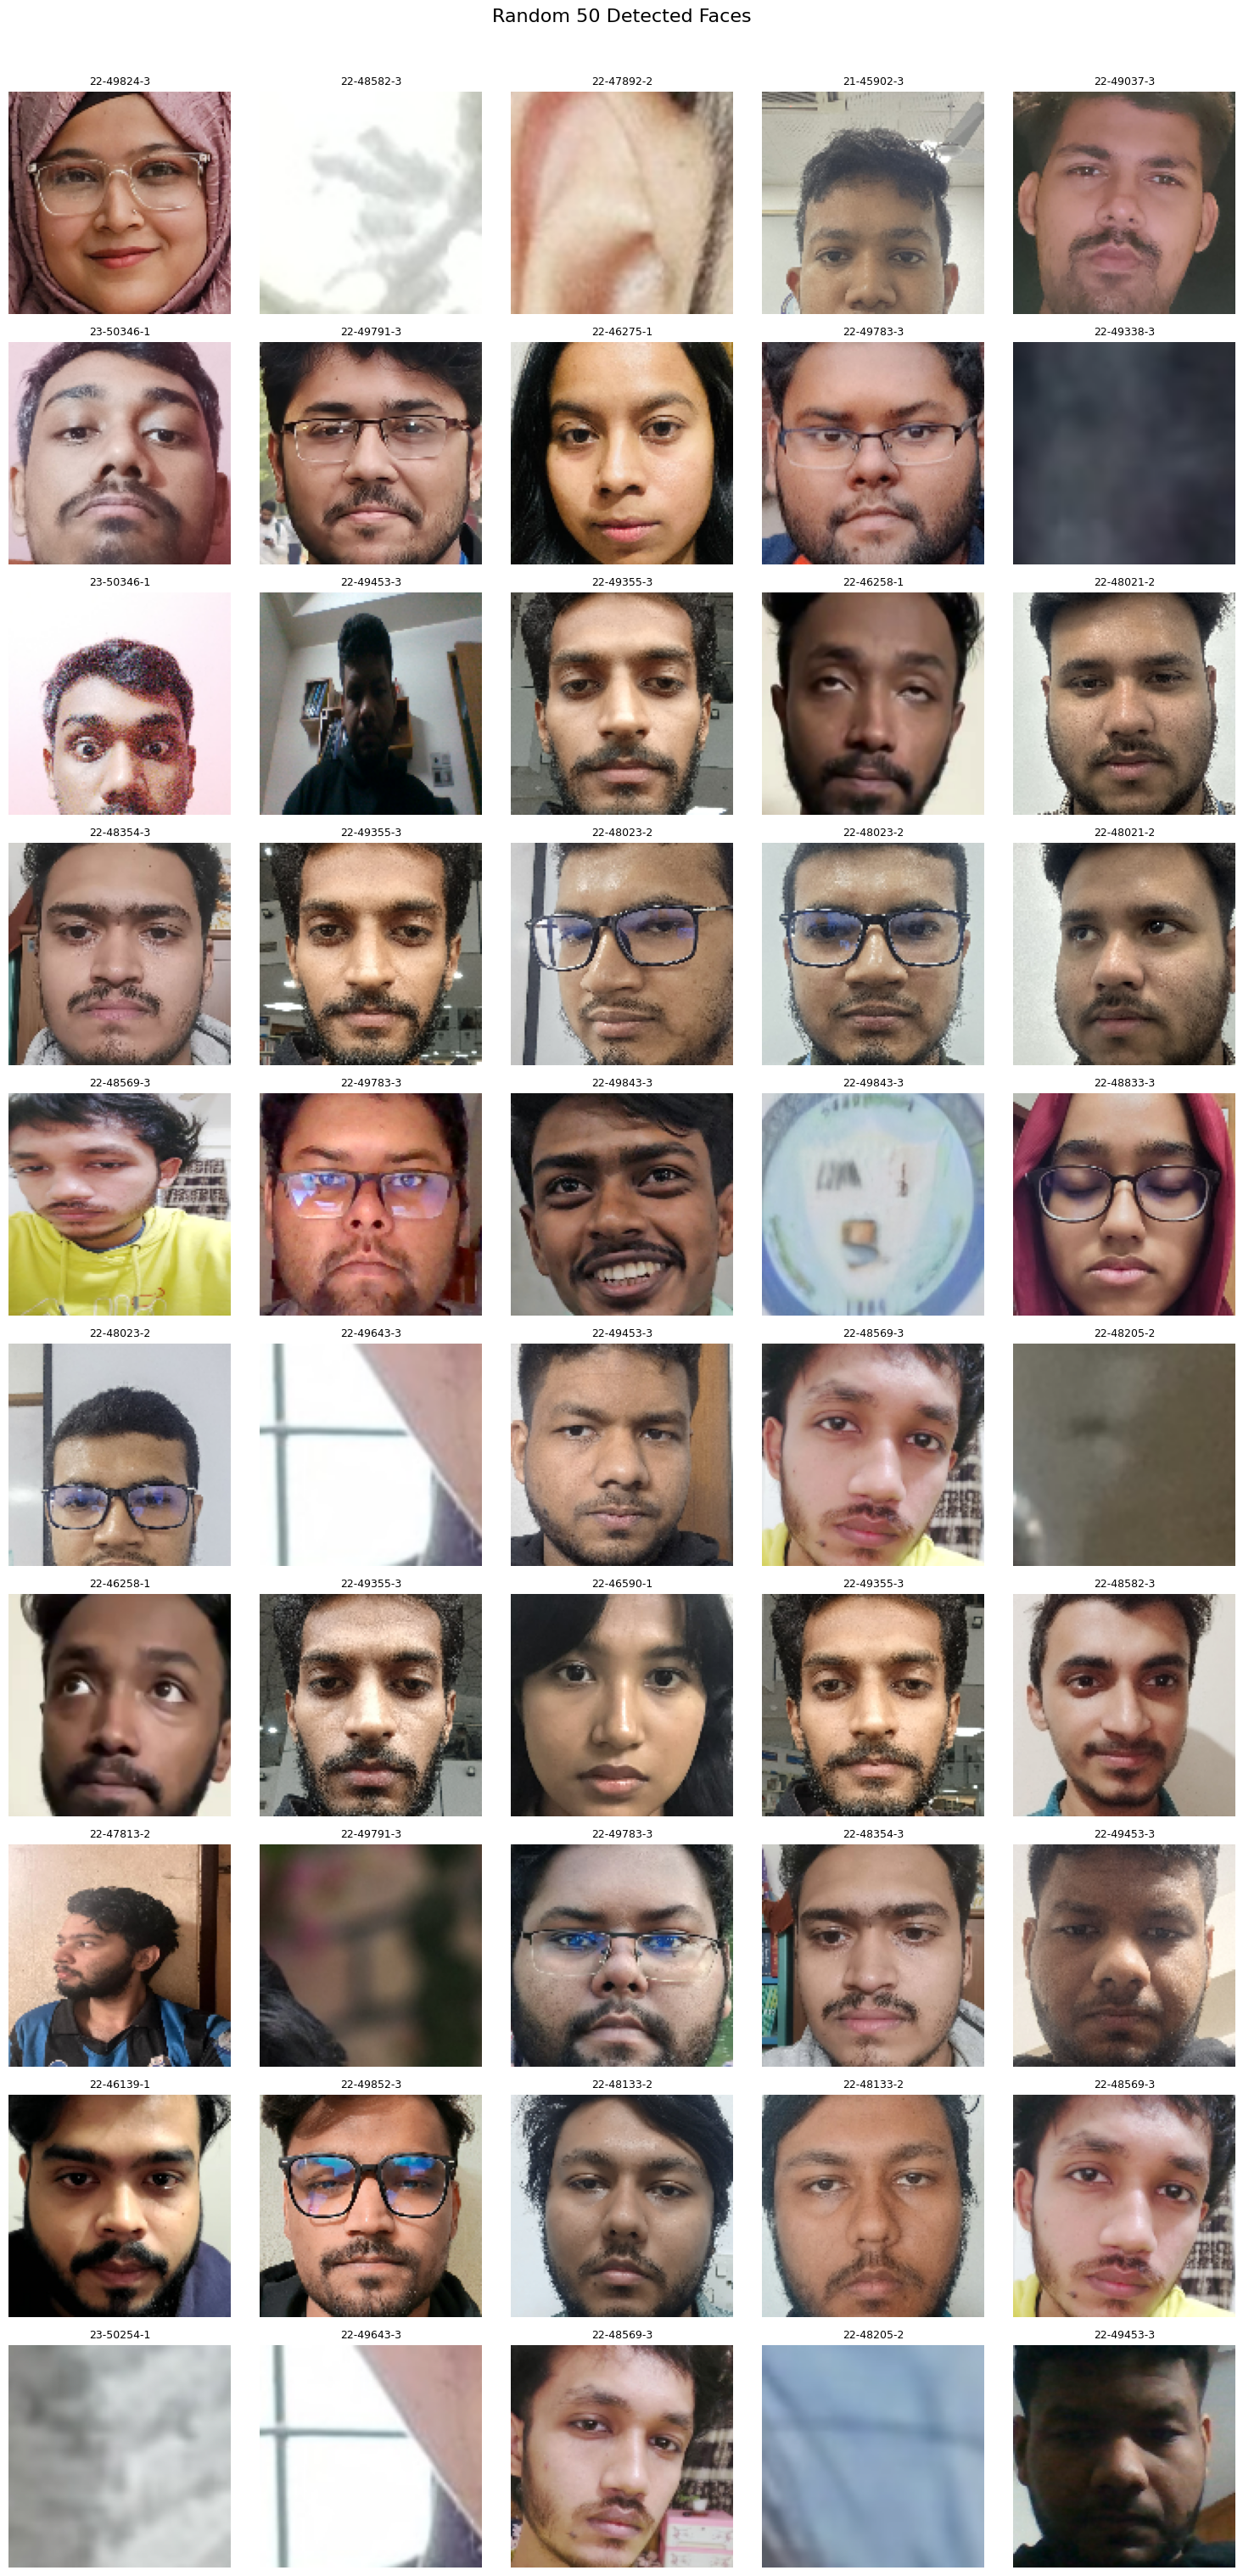

In [7]:

num_samples = 50
cols = 5
rows = 10

indices = np.random.choice(len(X), 50, replace=False)
    
plt.figure(figsize=(15, 3 * rows)) # Adjust height based on number of rows

for i, idx in enumerate(indices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[idx])
        
    label_idx = y[idx]
             
    plt.title(class_names[label_idx], fontsize=9)
    plt.axis('off')

plt.suptitle(f"Random {num_samples} Detected Faces", y=1.01, fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

print("Normalizing pixel values...")
X_norm = X.astype('float32') / 255.0

# One-Hot Encode Labels
# Converts class '0' -> [1, 0, 0, ...], class '1' -> [0, 1, 0, ...]
num_classes = len(class_names)
y_encoded = to_categorical(y, num_classes)

print(f"Data range after normalization: {X_norm.min()} to {X_norm.max()}")
print(f"Labels shape: {y_encoded.shape}")

# Split into Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X_norm, 
    y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training Data Shape:   {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")

Normalizing pixel values...
Data range after normalization: 0.0 to 1.0
Labels shape: (658, 35)
Training Data Shape:   (526, 128, 128, 3)
Validation Data Shape: (132, 128, 128, 3)


In [9]:
# Model Building (ResNet50V2 - High Accuracy)
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(num_classes, img_size=128):
    # Input Layer
    inputs = Input(shape=(img_size, img_size, 3))

    # Base Model (ResNet50V2)
    base_model = ResNet50V2(input_tensor=inputs, 
                            weights='imagenet', 
                            include_top=False)
    
    # Freeze the base model initially
    base_model.trainable = False

    # Add Custom Head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Increased dense layer size for better feature retention
    x = Dense(256, activation='relu')(x) 
    x = Dropout(0.5)(x) 
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Combine
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Build the model
num_classes = len(class_names)
model = build_model(num_classes, IMG_SIZE)

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
print(" ResNet50V2 Model created and compiled.")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 34, 34,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_0_c

 Total params: 24,098,339 (91.93 MB)

 Trainable params: 533,539 (2.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 ResNet50V2 Model created and compiled.


Starting Training...
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.0753 - loss: 4.4281 - val_accuracy: 0.4318 - val_loss: 2.4855
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 912ms/step - accuracy: 0.3969 - loss: 2.2035 - val_accuracy: 0.5682 - val_loss: 1.9259
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 879ms/step - accuracy: 0.5778 - loss: 1.5518 - val_accuracy: 0.6288 - val_loss: 1.6367
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 904ms/step - accuracy: 0.7120 - loss: 1.0978 - val_accuracy: 0.6742 - val_loss: 1.3960
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 928ms/step - accuracy: 0.8092 - loss: 0.7925 - val_accuracy: 0.6818 - val_loss: 1.3519
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 898ms/step - accuracy: 0.8614 - loss: 0.6056 - val_accuracy: 0.6970 - val_loss: 1.2664
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 930ms/step - accuracy: 0.9193 - loss: 0.3684 - val_accuracy: 0.6970 - val_loss: 1.2516
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 914ms/step - accuracy: 0.9076 - loss:

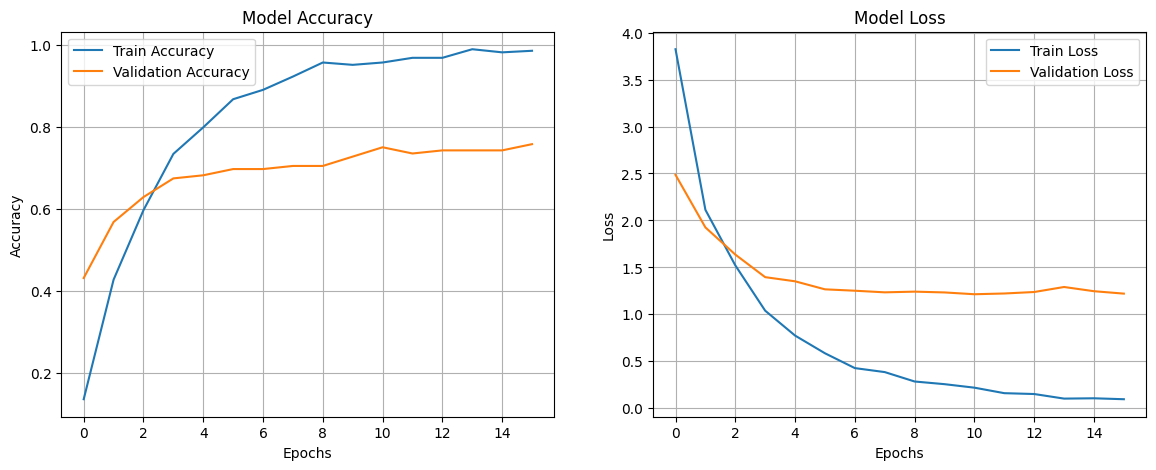

In [10]:
# Model Training
from tensorflow.keras.callbacks import  EarlyStopping

BATCH_SIZE = 32   # Number of images to process at once 
EPOCHS = 30       # Maximum number of times to go through the data


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


print("Starting Training...")

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks= early_stopping, 
    verbose=1
)

print(" Training Complete.")

# Visualize Training Results
# Plot Accuracy and Loss
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Model Evaluation 
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Get Predictions on Validation Data
print("Evaluating on Validation Set...")
y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

all_label_ids = np.arange(len(class_names))

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=class_names, 
    labels=all_label_ids 
))

# Plot Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=all_label_ids)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

Testing on file: /kaggle/input/cvpr-face-data-35-student/CVPR_face_data/22-48005-2/20260106_170407.jpg


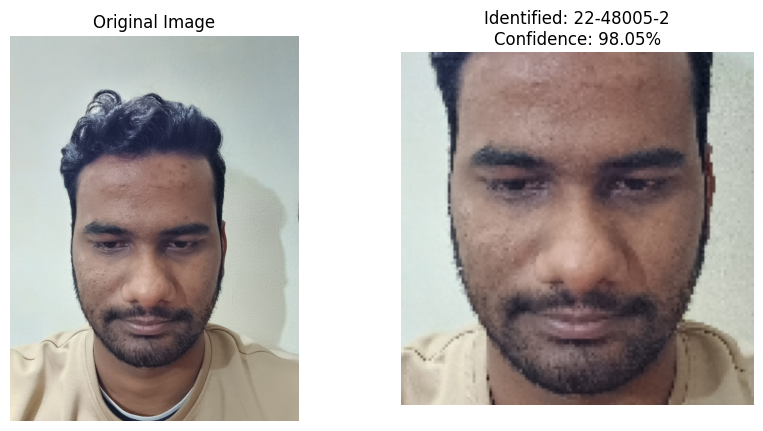

(np.str_('22-48005-2'), np.float32(98.049835))

In [15]:
import random

# Final Prediction System
def predict_student(image_path):
    """
    Full pipeline: Load Image -> Detect Face -> Crop -> Predict -> Visualize
    """
    if not os.path.exists(image_path):
        print(" Image path not found.")
        return

    # Detect and Crop Face 
    cropped_face = detect_and_crop_face(image_path, target_size=(128, 128))
    
    if cropped_face is None:
        print(" No face detected in the image.")
        return

    # Normalize (0-1) and add batch dimension (1, 128, 128, 3)
    img_array = np.expand_dims(cropped_face, axis=0).astype('float32') / 255.0

    # Predict
    probs = model.predict(img_array, verbose=0)
    pred_index = np.argmax(probs)
    confidence = np.max(probs) * 100
    pred_name = class_names[pred_index]

    # Visualization
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cropped_face)
    plt.title(f"Identified: {pred_name}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    
    plt.show()
    
    return pred_name, confidence


random_class = '22-48005-2'
random_folder = os.path.join(KAGGLE_DATASET_PATH, random_class)
random_file = random.choice(os.listdir(random_folder))
test_path = os.path.join(random_folder, random_file)

print(f"Testing on file: {test_path}")
predict_student(test_path)

Testing on file: /kaggle/input/cvpr-face-data-35-student/CVPR_face_data/22-48005-2/20260106_170412.jpg


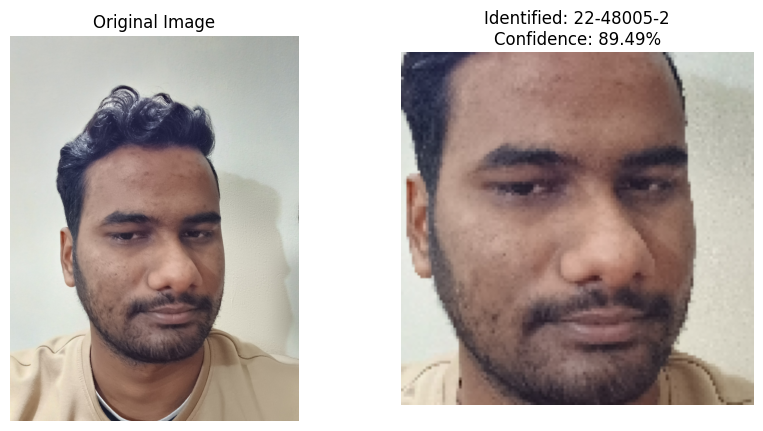

(np.str_('22-48005-2'), np.float32(89.492424))

In [16]:
random_class = '22-48005-2'
random_folder = os.path.join(KAGGLE_DATASET_PATH, random_class)
random_file = random.choice(os.listdir(random_folder))
test_path = os.path.join(random_folder, random_file)

print(f"Testing on file: {test_path}")
predict_student(test_path)

Testing on file: /kaggle/input/cvpr-face-data-35-student/CVPR_face_data/22-47934-2/20260106_165042.jpg


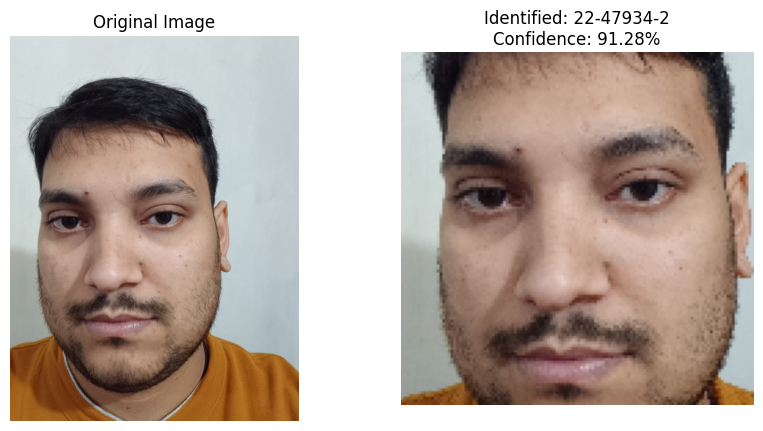

(np.str_('22-47934-2'), np.float32(91.276726))

In [17]:
random_class = '22-47934-2'
random_folder = os.path.join(KAGGLE_DATASET_PATH, random_class)
random_file = random.choice(os.listdir(random_folder))
test_path = os.path.join(random_folder, random_file)

print(f"Testing on file: {test_path}")
predict_student(test_path)

In [21]:
import json

model_save_path = "/kaggle/working/face_model.keras"
print(f"Saving model to {model_save_path}...")
model.save(model_save_path)

class_names_path = "/kaggle/working/class_names.json"
print(f"Saving class names to {class_names_path}...")
with open(class_names_path, 'w') as f:
    json.dump(class_names.tolist(), f)


Saving model to /kaggle/working/face_model.keras...
Saving class names to /kaggle/working/class_names.json...


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


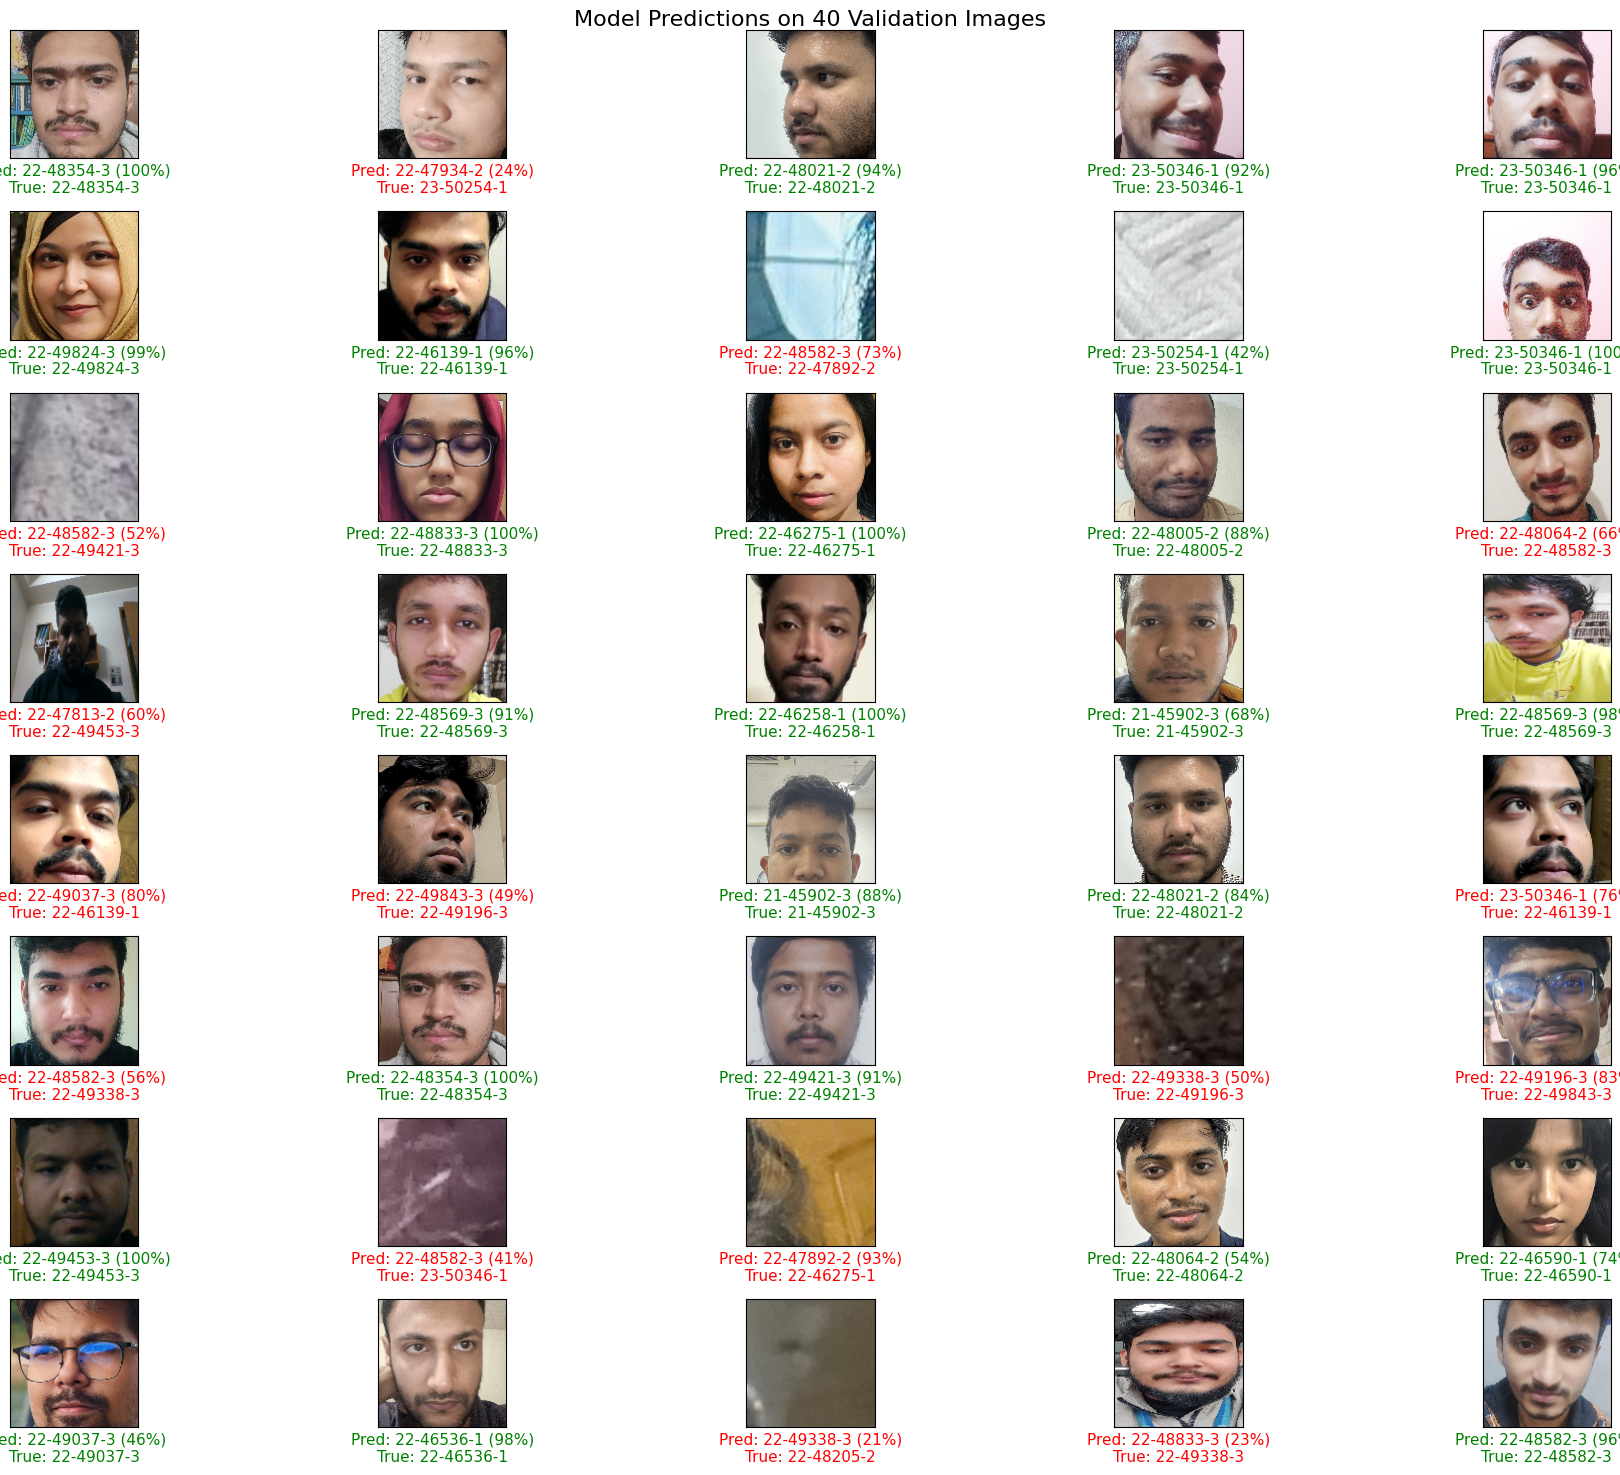

In [22]:
# Visualize 20 Predictions
import matplotlib.pyplot as plt
import numpy as np


num_images = 40
X_batch = X_val[:num_images]
y_batch = y_val[:num_images]

predictions = model.predict(X_batch)

rows = 8
cols = 5
plt.figure(figsize=(20, 15))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    
    # Display Image
    plt.imshow(X_batch[i])
    plt.xticks([])
    plt.yticks([])
    
    # Get True and Predicted Labels
    true_index = np.argmax(y_batch[i])
    pred_index = np.argmax(predictions[i])
    confidence = 100 * np.max(predictions[i])
    
    true_label = class_names[true_index]
    pred_label = class_names[pred_index]
    
    # Set Color: Green for Correct, Red for Incorrect
    color = 'green' if true_index == pred_index else 'red'
    
    # Label Format: "Pred (Conf%) \n [Actual]"
    label_text = f"Pred: {pred_label} ({confidence:.0f}%)\nTrue: {true_label}"
    
    plt.xlabel(label_text, color=color, fontsize=11)

plt.suptitle(f"Model Predictions on {num_images} Validation Images", fontsize=16)
plt.tight_layout()
plt.show()